<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/CommunitiesCommute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we illustrate the use of commute times and the associated spectral embedding to find communities in the Zachary's network.

In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

# Load the Zachary's Karate Club graph
G = nx.karate_club_graph()

Let us compute and show the Laplacian matrix of the graph (L=D-A)...

In [16]:
# Get the adjacency matrix as a NumPy array
A = nx.to_numpy_array(G)

# Convert any positive weights in the adjacency matrix to 1
# This step ensures the adjacency matrix is unweighted
A_unweighted = np.where(A > 0, 1, 0)

# Compute the degrees as the sum of unweighted adjacency matrix rows
degrees = np.sum(A_unweighted, axis=1)

# Create the degree matrix D
D = np.diag(degrees)

# Compute the Laplacian matrix L = D - A_unweighted
L = D - A_unweighted

# Display the unweighted Laplacian Matrix
print("Unweighted Laplacian Matrix:\n", L)

Unweighted Laplacian Matrix:
 [[16 -1 -1 ... -1  0  0]
 [-1  9 -1 ...  0  0  0]
 [-1 -1 10 ...  0 -1  0]
 ...
 [-1  0  0 ...  6 -1 -1]
 [ 0  0 -1 ... -1 12 -1]
 [ 0  0  0 ... -1 -1 17]]


We now compute the eigendecomposition of the Laplacian Matrix L...

In [17]:
# Compute the eigendecomposition of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Display the eigenvalues and the first few eigenvectors
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors (first few):\n", eigenvectors[:, :3])

Eigenvalues:
 [-1.91601452e-15  4.68525227e-01  9.09247664e-01  1.12501072e+00
  1.25940411e+00  1.59928308e+00  1.76189862e+00  1.82605521e+00
  1.95505045e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.48709173e+00  2.74915718e+00
  3.01396297e+00  3.24206748e+00  3.37615409e+00  3.38196601e+00
  3.47218740e+00  4.27587682e+00  4.48000767e+00  4.58079267e+00
  5.37859508e+00  5.61803399e+00  6.33159222e+00  6.51554463e+00
  6.99619703e+00  9.77724095e+00  1.09210675e+01  1.33061223e+01
  1.70551712e+01  1.81366960e+01]
Eigenvectors (first few):
 [[ 0.17149859 -0.11213743  0.06940423]
 [ 0.17149859 -0.04128789  0.09514749]
 [ 0.17149859  0.02321896  0.04270411]
 [ 0.17149859 -0.05549978  0.10584319]
 [ 0.17149859 -0.28460453 -0.12126623]
 [ 0.17149859 -0.32372722 -0.20167565]
 [ 0.17149859 -0.32372722 -0.20167565]
 [ 0.17149859 -0.052586    0.10130188]
 [ 0.17149859  0.05160128  0.01467707]
 [ 0.17149859  0.09280089  0.01311954]
 [ 0.17149859 -

We observe that the smallest eigenvalue is practically zero, indicating a single CC.
Let's compute the matrix of commute times...

In [23]:
# Number of edges in the graph, m
m = G.size()

# Number of nodes in the graph
n = G.number_of_nodes()

# Initialize the matrix of commute times with zeros
commute_times = np.zeros((n, n))

# Compute the commute times for each pair of nodes
for i in range(n):
    for j in range(n):
        # Sum over all nontrivial eigenvalues (excluding the first one)
        sum_over_k = np.sum([(eigenvectors[k, i] - eigenvectors[k, j])**2 / eigenvalues[k]
                             for k in range(1, n)])  # Excluding the first eigenvalue
        commute_times[i, j] = m * sum_over_k

print("Commute times matrix:\n", commute_times)


Commute times matrix:
 [[ 0.         83.19197667 60.62295477 ... 42.50471761 18.93770298
  43.85983557]
 [83.19197667  0.         64.03266864 ... 40.14599275 46.19205709
  38.41092654]
 [60.62295477 64.03266864  0.         ... 55.82437713 35.34341962
  43.12389866]
 ...
 [42.50471761 40.14599275 55.82437713 ...  0.         15.16621645
  20.61067808]
 [18.93770298 46.19205709 35.34341962 ... 15.16621645  0.
   8.11458628]
 [43.85983557 38.41092654 43.12389866 ... 20.61067808  8.11458628
   0.        ]]


Instead of using this distance matrix to create an embedding using MDS, we can create the embedding directly from the eigenvalues and eigenvectors of the Laplacian, as follows.

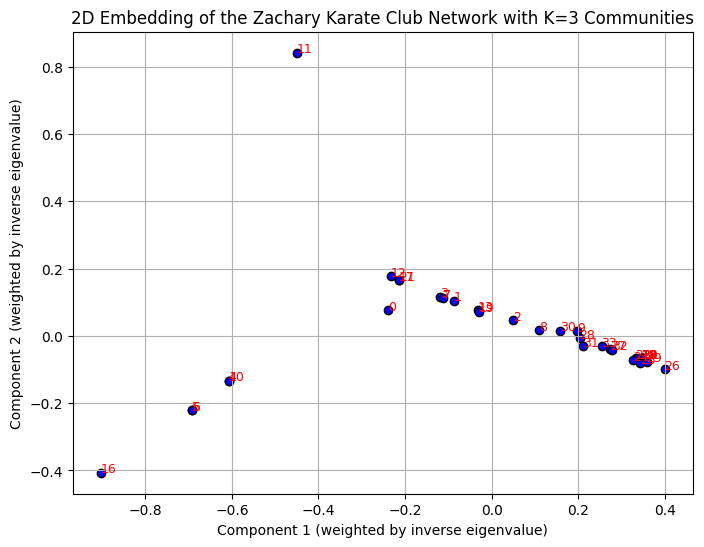

In [25]:
# Set K to the number of communities, and d to K-1 for the embedding dimension
K = 3
d = K - 1  # The dimension of the embedding

# Select the first d nontrivial eigenvectors (since K=3, select 2 eigenvectors)
eigenvectors_nontrivial = eigenvectors[:, 1:d+1]

# Compute the inverse of the first d nontrivial eigenvalues
inverse_eigenvalues = 1 / eigenvalues[1:d+1]

# Weight each column of the eigenvectors by the inverse of the corresponding eigenvalue
embedding = eigenvectors_nontrivial * inverse_eigenvalues.reshape(1, d)

# Plot the 2D embedding
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', marker='o', edgecolor='k')
for i in range(embedding.shape[0]):
    plt.text(embedding[i, 0], embedding[i, 1], str(i), color='red', fontsize=9)
plt.title('2D Embedding of the Zachary Karate Club Network with K=3 Communities')
plt.xlabel('Component 1 (weighted by inverse eigenvalue)')
plt.ylabel('Component 2 (weighted by inverse eigenvalue)')
plt.grid(True)
plt.show()

Let's cluster the nodes using K-means and show the resulting graph

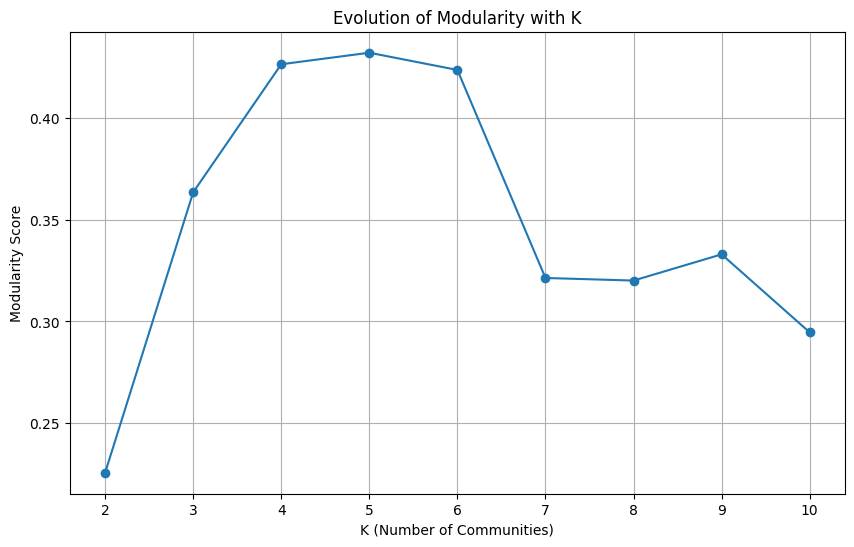

The optimal value of the modularity score is: 0.43191656828020464


In [39]:
# Assuming eigenvalues and eigenvectors are available from the Laplacian matrix of the graph
modularity_scores = []
K_values = range(2, 11)

for K in K_values:
    d = K - 1
    # Prepare the embedding
    eigenvectors_nontrivial = eigenvectors[:, 1:d+1]
    inverse_eigenvalues = 1 / eigenvalues[1:d+1]
    embedding = eigenvectors_nontrivial * inverse_eigenvalues.reshape(1, d)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(embedding)
    labels = kmeans.labels_

    # Compute the modularity score
    G = nx.karate_club_graph()  # Ensure the graph G is defined and available
    partition = {i: labels[i] for i in range(len(labels))}
    modularity = nx.algorithms.community.modularity(G, communities=[set(np.where(labels == i)[0]) for i in range(K)])
    modularity_scores.append(modularity)

# Plot Modularity vs. K
plt.figure(figsize=(10, 6))
plt.plot(K_values, modularity_scores, marker='o', linestyle='-')
plt.title('Evolution of Modularity with K')
plt.xlabel('K (Number of Communities)')
plt.ylabel('Modularity Score')
plt.xticks(K_values)
plt.grid(True)
plt.show()

print('The optimal value of the modularity score is:', modularity_scores[3])

The optimal number of communities using the reduced-order commute distance (aka Laplacian spectral clustering) is K=5. The graph is plotted below...

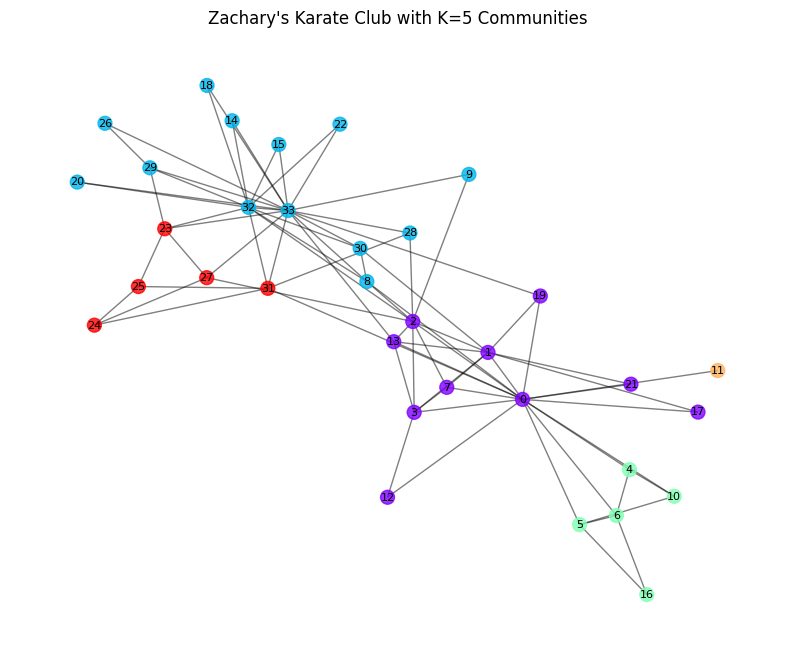

In [29]:
# Assuming eigenvalues and eigenvectors are defined, let's set K=5 for the clustering
K = 5
d = K - 1

# Select the first d nontrivial eigenvectors for the embedding
eigenvectors_nontrivial = eigenvectors[:, 1:d+1]
inverse_eigenvalues = 1 / eigenvalues[1:d+1]
embedding = eigenvectors_nontrivial * inverse_eigenvalues.reshape(1, d)

# Perform K-means clustering on the embedding
kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(embedding)
labels = kmeans.labels_

# Load the graph (assuming it's the Zachary's Karate Club graph)
G = nx.karate_club_graph()

# Plot the graph with nodes colored by their community
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm

# Draw nodes with colors based on their cluster labels
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.rainbow, node_color=labels, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Zachary\'s Karate Club with K=5 Communities')
plt.axis('off')
plt.show()